<a href="https://colab.research.google.com/github/sarav18302/neural-networks/blob/master/yolov3_objectdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 15490 (delta 10), reused 18 (delta 8), pack-reused 15460
Receiving objects: 100% (15490/15490), 14.10 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (10395/10395), done.


In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights


--2022-08-22 16:22:02--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  74.9MB/s    in 3.3s    

2022-08-22 16:22:05 (71.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [3]:
import cv2
import numpy as np
from glob import glob
from google.colab.patches import cv2_imshow
import os


In [ ]:
#initialising a DNN with pre trained weights
net = cv2.dnn.readNet('/content/yolov3.weights', '/content/darknet/cfg/yolov3.cfg')


In [ ]:
classes = []
with open("/content/darknet/data/coco.names", "r") as f:
    classes = f.read().splitlines()
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
#to check or create directory needed
def create_dir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"ERROR: creating directory with name {path}")

#function to capture keyframes with gap
def save_frame(video_path, save_dir, gap=10):
  

  cap = cv2.VideoCapture(video_path)
  idx = 0

  while True:
      ret, frame = cap.read()

      if ret == False: #no video is present
          cap.release()
          break
      #idx represent timestamp of frames in a video
      if idx == 0:
          cv2.imwrite(f"{save_dir}/{idx}.jpg", frame)
      else:
        #to capture key frames with a gap
          if idx % gap == 0:
            #writing the images according to their timestamps
              cv2.imwrite(f"{save_dir}/{idx}.jpg", frame)

      idx += gap




In [ ]:
def prediction(video_path, save_dir, gap=10):
  #generating key frames
  save_frame(video_path, save_dir, gap=10)
  no_of_boxes=0
  files=[]

  
  for filename in os.listdir(save_dir):
   
    if not filename.startswith('.') :
      if filename not in files:
        img= cv2.imread(save_dir+str('/')+filename)
        #to print the frame currently taken
        print("file",filename)
        font = cv2.FONT_HERSHEY_PLAIN
        colors = np.random.uniform(0, 255, size=(100, 3))
        height, width, _ = img.shape
        #normalisation of image
        blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
        net.setInput(blob)

        output_layers_names = net.getUnconnectedOutLayersNames()
        layerOutputs = net.forward(output_layers_names) 

        boxes = []
        confidences = []
        class_ids = []
        for output in layerOutputs:
          for detection in output:
              scores = detection[5:]
              class_id = np.argmax(scores)
              confidence = scores[class_id]
              if confidence > 0.2:
                  center_x = int(detection[0]*width)
                  center_y = int(detection[1]*height)
                  w = int(detection[2]*width)
                  h = int(detection[3]*height)

                  x = int(center_x - w/2)
                  y = int(center_y - h/2)

                  boxes.append([x, y, w, h])
                  confidences.append((float(confidence)))
                  class_ids.append(class_id)
          indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)
          if(no_of_boxes<len(indexes)):
            no_of_boxes=len(indexes)
            img_max_obj=filename
            timestamp=filename.split(".")[0] # timestamp at which highest no of objects found

          if len(indexes)>0:
            for i in indexes.flatten():
              x, y, w, h = boxes[i]
              label = str(classes[class_ids[i]])
              confidence = str(round(confidences[i],2))
              color = colors[i]
              cv2.rectangle(img, (x,y), (x+w, y+h), color, 10)
              cv2.putText(img, label + " " + confidence, (x, y+20), font, 10, (255,255,255), 2)
              #labelled images are stored here 
              out_fname='/content/output_images/'+filename
              cv2.imwrite(out_fname, img)
        files.append(filename)   
         
  #display images with highest no of objects  
  #imgS=cv2.imread('/content/output_images/'+img_max_obj)    
  #cv2_imshow(imgS)
  return timestamp



  
      
  

     
     
                         
  

In [ ]:
video_paths = "/content/videos/vid1.mp4"
save_dir = "/content/frames"
print("timestamp with highest no of objects" ,prediction(path,save_dir,gap=100))

file 160.jpg
file 220.jpg
file 10.jpg
file 300.jpg
file 190.jpg
file 110.jpg
file 320.jpg
file 240.jpg
file 260.jpg
file 80.jpg
file 40.jpg
file 150.jpg
file 290.jpg
file 400.jpg
file 250.jpg
file 350.jpg
file 380.jpg
file 340.jpg
file 90.jpg
file 170.jpg
file 310.jpg
file 140.jpg
file 30.jpg
file 270.jpg
file 360.jpg
file 120.jpg
file 390.jpg
file 200.jpg
file 280.jpg
file 70.jpg
file 130.jpg
file 230.jpg
file 50.jpg
file 60.jpg
file 330.jpg
file 0.jpg
file 20.jpg
file 370.jpg
file 180.jpg
file 210.jpg
file 100.jpg
timestamp with highest no of objects 80


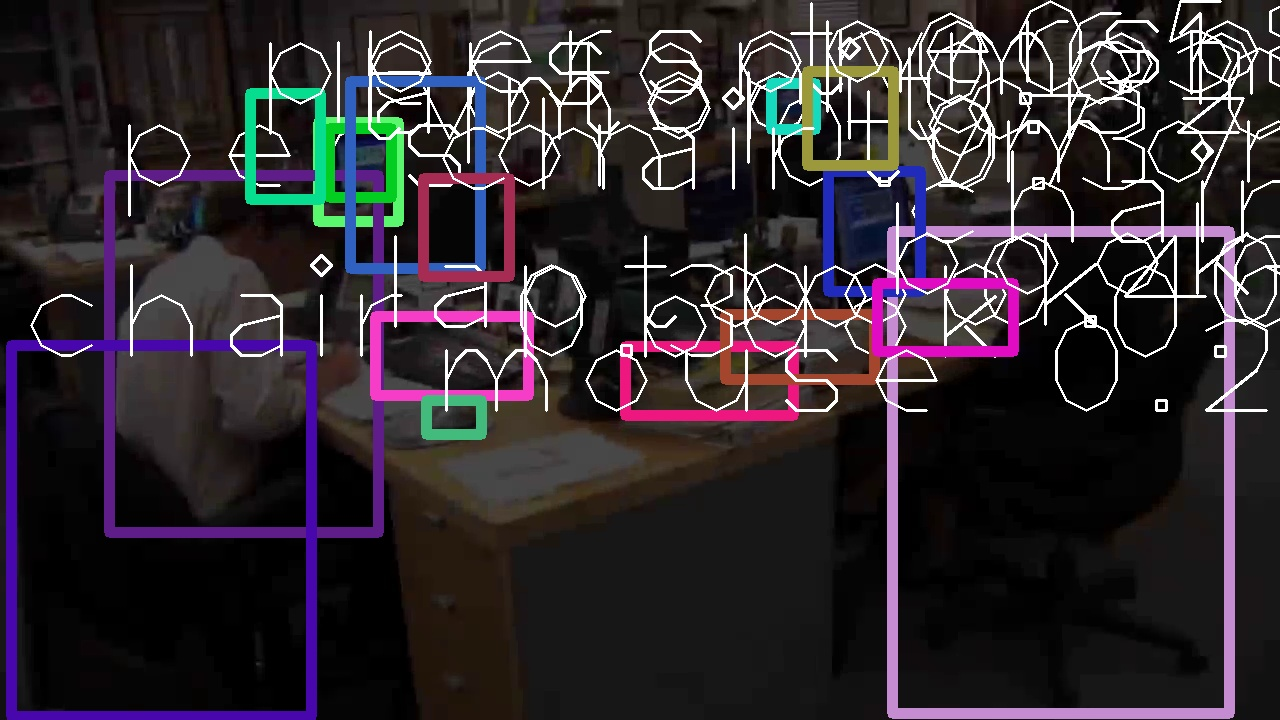

In [ ]:
#to display image with highest no of objects
imgS=cv2.imread('/content/output_images/80.jpg')    
cv2_imshow(imgS)